In [ ]:
import os
import torch
from model import GPTConfig, GPT
import pickle
from tqdm import tqdm
import networkx as nx
import json
import sys


def load_basic_infor(checkpoint,meta_path):
    
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)

        
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    return model,meta

method='adj'
out_dir = ''
device='cuda:2'
triangle_num, pattern_list, method=[1],['diamond'],'adj'
define_method='term'

pattern_name_list=''
for p in pattern_list:
    pattern_name_list+=p
triangle_num_string=''
for t in triangle_num:
    triangle_num_string+=str(t)
scale=2000000
sub_scale=400000
n_embd=384
seed=0
n_layer=4
n_head=12
model_scale={384:'small',768:'mid',1024:'large'}
base_path=f''
out_dir=base_path+f'/model_{pattern_name_list}_{triangle_num_string}_{method}_{define_method}_{model_scale[n_embd]}_{n_layer}_{n_head}_{sub_scale}_{seed}'

ckpt_path = os.path.join(out_dir, f'model.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
meta_path = os.path.join('data', checkpoint['config']['dataset'], f'{base_path}/my_meta_{define_method}_{pattern_name_list}_{triangle_num_string}_{method}.pkl')

model,meta=load_basic_infor(checkpoint,meta_path)
model.to(device)
model.eval()
print(meta['stoi'])

stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ' '.join([itos[i] for i in l])

question_max_length=meta['max_questions']
ans_max_length=meta['max_ans']

number of parameters: 7.09M
Loading meta from /egr/research-dselab/shared/daixinna/nano-pattern/tiny_models/my_meta_term_diamond_1_adj.pkl...
{'': 0, ',': 1, '0': 2, '1': 3, '10': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, ':': 18, '<END>': 19, '<END_Q>': 20, '<PAD>': 21, '<START_A>': 22, '<START_Q>': 23, 'diamond': 24}


In [2]:
def parse_directed_graph_to_nx(graph_str):
    G = nx.DiGraph()
    entries = [entry.strip() for entry in graph_str.split(',')]
    for entry in entries:
        if ':' in entry:
            node_str, neighbors_str = entry.split(':')
            node = int(node_str.strip())
            neighbors = [int(n) for n in neighbors_str.strip().split()] if neighbors_str.strip() else []
            for neighbor in neighbors:
                G.add_edge(node, neighbor)
        else:
            node = int(entry.strip())
            G.add_node(node)  # In case it's an isolated node with no neighbors
    return G

In [ ]:
START_Q='<START_Q> '
END_Q=' <END_Q>'
START_A='<START_A>'
PAD=' <PAD>'
IN_LABEL='T'
OTHERS='O'
TARGET='A'
PRED_ANS='P'
PAIRS='N'
COMS='S'

label_dicts={0:'A',1:'B',2:'C',3:'D'}

def construct_Q(txts,pairs,ans_nodes):
    questions=''
    pad_string=''
    nodes=pairs.split(' ')[2:]
    labels=''
    label_list=[]
    ans_nodes=ans_nodes.split(' ')
    for idx,txt in enumerate(txts.split('|')):
        nums=2
        if txt in ans_nodes:
            labels+=IN_LABEL
        else:
            labels+=IN_LABEL
        

        if idx!=len(txts.split('|'))-1:
            labels+=COMS
    
    
    # generate the input data
    for i in range(question_max_length-(len(txts.split(' '))+len(pairs.split(' ')))-2):
        pad_string+=PAD
    single_data=START_Q+txts+pad_string+' '+pairs+' '+START_A
    pad_string=''
    for i in range(ans_max_length):
        pad_string+=PAD
    questions+=single_data+pad_string
    question_list=questions.split(' ')
    for idx,i in enumerate(question_list):
        if i in ans_nodes and i!=',':
            label_string='L_'+label_dicts[ans_nodes.index(i)]
            # label_list.append('L_'+label_dicts[ans_nodes.index(i)])
        else:
            label_string=OTHERS
            # label_list.append(OTHERS)
        if idx!=len(question_list)-1:
            if question_list[idx+1]==':':
                label_string='(S)'+label_string
        label_list.append(label_string)

    return questions, label_list

def load_data(triangle_num, pattern_list, method, given_idx=0):
    print(pattern_list)
    data_base_path=f''
    x_list=[]
    x_length=[]
    ans=[]
    G=[]
    label_list=[]
    string_list=[]
    
    for i in range(1,30):
        with open(os.path.join(data_base_path,f'tiny_{i}_idx.json'),'r') as f:
            graph_dicts=json.load(f)

        with open(os.path.join(data_base_path,f'tiny_{i}_graphs_description_{method}.pkl'),'rb') as f:
            graph_description_list=pickle.load(f)
            
        with open(os.path.join(data_base_path,f'tiny_{i}_ans.pkl'),'rb') as f:
            ans_list=pickle.load(f)
        
        with open(os.path.join(data_base_path,f'tiny_{i}_graphs.pkl'),'rb') as f:
            graph_list=pickle.load(f)

        for p in pattern_list:
            for t in triangle_num:
                idx=graph_dicts[p+str(t)]
            
                ans.extend([ans_list[i][p] for i in idx])
                current_ans=[ans_list[i][p] for i in idx]
                descriptions=[graph_description_list[i] for i in idx]
                for idx,txt in enumerate(descriptions):
                    nodes_str=p# f' between {nodes_list[idx][0]} {nodes_list[idx][1]}'
                    start, labels=construct_Q(txt,nodes_str,current_ans[idx])
                    graph=parse_directed_graph_to_nx(txt[1:])
                    G.append(parse_directed_graph_to_nx(txt[1:]))
                    label_list.append(labels)
                    string_list.append(start.split(' '))
                    lens=len(txt.split(' '))
                    x_length.append(len(txt.split(' ')))
                    start_ids = encode(start.split(' '))
                    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
                    x_list.append(x)
    return x_length,x_list,string_list,ans,label_list,G#,nodes_list
x_length,sentence_id,string_list,ans,label_list,g_list=load_data(triangle_num, pattern_list, method,given_idx=None)


['diamond']


In [4]:
ans_dicts={}
for idx,g in tqdm(enumerate(ans),total=len(ans)):
    if g not in ans_dicts:
        ans_dicts[g]=0
    ans_dicts[g]+=1
sorted_dict = dict(sorted(ans_dicts.items(), key=lambda item: item[1],reverse=True))
sorted_dict_list = list(sorted_dict.keys())
print(sorted_dict)

  0%|          | 0/54203 [00:00<?, ?it/s]

100%|██████████| 54203/54203 [00:00<00:00, 2161597.54it/s]

{'0 4 3 1 ,': 58, '2 4 1 3 ,': 53, '2 1 3 0 ,': 50, '3 0 2 4 ,': 50, '1 0 4 3 ,': 50, '2 4 3 1 ,': 49, '1 0 4 2 ,': 49, '2 1 4 0 ,': 49, '3 0 4 1 ,': 48, '1 2 0 3 ,': 48, '1 4 3 0 ,': 47, '4 0 2 1 ,': 46, '4 0 3 2 ,': 46, '4 2 3 1 ,': 46, '0 4 2 1 ,': 45, '3 4 1 0 ,': 45, '1 3 4 2 ,': 44, '3 2 4 1 ,': 44, '0 1 4 3 ,': 44, '4 3 0 1 ,': 44, '3 1 2 0 ,': 44, '2 4 1 0 ,': 43, '3 2 1 4 ,': 43, '4 0 3 1 ,': 43, '3 4 0 2 ,': 43, '2 4 0 3 ,': 43, '1 0 2 4 ,': 42, '2 1 0 4 ,': 42, '2 0 1 3 ,': 42, '0 2 1 4 ,': 42, '0 2 3 1 ,': 41, '3 1 0 2 ,': 41, '4 2 0 3 ,': 41, '1 0 2 3 ,': 41, '4 3 2 1 ,': 41, '3 1 4 0 ,': 41, '4 2 1 3 ,': 40, '1 3 0 2 ,': 40, '0 3 2 4 ,': 40, '2 1 4 3 ,': 40, '1 3 2 4 ,': 40, '3 0 5 1 ,': 40, '4 3 1 2 ,': 40, '2 4 3 0 ,': 40, '2 1 3 4 ,': 39, '1 0 3 2 ,': 39, '3 1 0 4 ,': 39, '4 0 1 2 ,': 39, '4 3 1 0 ,': 39, '1 2 4 5 ,': 39, '1 3 0 4 ,': 39, '1 3 2 0 ,': 39, '4 0 2 3 ,': 39, '2 5 4 1 ,': 39, '0 1 2 4 ,': 39, '1 4 0 2 ,': 38, '0 2 1 3 ,': 38, '2 3 0 1 ,': 38, '0 2 4 1 ,': 

In [5]:
color_map={'2 ': "#8B0000", 
            '1 ':"#2E8B57", 
            '3 ':"#6171CB", 
            '0 ':"#696969",
            '3 0 ':"#4169E1", 
            '1 0 ':"#34AE53", 
            '0 4 ':"#9b9b9b", 
            '2 4 ':"#FF1493", 
            '2 1 ':"#B22222",
            '2 4 1 ':"#FF69B4", 
            '2 1 4 ':"#DC143C", 
            '2 4 3 ':"#F55F7A", 
            '1 0 4 ':"#32CD32", 
            '0 4 3 ':"#B4B4B4", 
            '2 1 3 ':"#FF4500", 
            '3 0 2 ':"#1E90FF", 
            '1 0 4 3 ':"#00FA9A", 
            '3 0 2 4 ':"#00BFFF", 
            '2 4 1 3 ':"#DA70D6", 
            '2 1 3 0 ':"#FFA07A",
            '0 4 3 1 ':"#E6E6E6", 
            '2 4 3 1 ':"#6171C8", 
            '2 1 4 0 ':"#CD5C5C", 
            '1 0 4 2 ':"#ADFF2F",}

In [ ]:


attn_list=[]
ans_label_list=[]
response_list=[]
attn_list_dicts={}
selected_idx=117
for idx,g in tqdm(enumerate(ans),total=len(ans)):
    if g[:-1] not in color_map:continue
    y,attn = model.generate(sentence_id[idx], ans_max_length,max_question_length=question_max_length,return_vis_value=True)
    response=decode(y[0].tolist())#[question_max_length:]
    if g not in response:continue
    response_txt=response.split(' ')
    for key in attn.keys():
        if key not in attn_list_dicts:
            attn_list_dicts[key]=[]
        attn_list_dicts[key].append(attn[key][:3])
    response_list.append(response.split(' '))
    ans_label_list.append(sorted_dict_list.index(g))
print(len(response_list))


  0%|          | 0/54203 [00:00<?, ?it/s]

100%|██████████| 54203/54203 [00:32<00:00, 1681.24it/s]

408


In [7]:
print(ans_label_list)

[0, 2, 5, 3, 5, 5, 0, 6, 2, 7, 4, 3, 3, 3, 3, 0, 2, 2, 7, 0, 0, 5, 1, 1, 5, 4, 4, 6, 1, 0, 1, 4, 1, 4, 5, 3, 6, 3, 0, 7, 4, 3, 7, 3, 2, 3, 0, 6, 3, 2, 4, 1, 1, 4, 7, 6, 2, 2, 6, 6, 6, 5, 2, 2, 6, 0, 0, 6, 0, 5, 2, 2, 4, 7, 3, 0, 3, 4, 6, 4, 6, 0, 0, 4, 6, 0, 5, 4, 1, 5, 1, 0, 7, 7, 0, 5, 2, 0, 7, 1, 3, 6, 6, 3, 1, 3, 2, 1, 4, 4, 0, 2, 3, 2, 2, 1, 1, 4, 3, 0, 1, 7, 6, 2, 3, 0, 2, 2, 0, 2, 2, 0, 0, 2, 3, 1, 2, 4, 4, 4, 1, 4, 3, 4, 1, 2, 2, 0, 7, 5, 6, 1, 0, 1, 4, 4, 5, 2, 5, 7, 2, 7, 6, 7, 0, 5, 2, 1, 5, 4, 3, 4, 7, 1, 7, 7, 3, 0, 0, 7, 5, 5, 5, 1, 0, 5, 3, 1, 0, 2, 0, 1, 3, 0, 1, 3, 1, 6, 7, 3, 1, 7, 5, 0, 4, 5, 6, 2, 3, 6, 5, 0, 6, 0, 3, 3, 0, 2, 1, 5, 1, 5, 6, 2, 5, 4, 7, 7, 7, 0, 7, 7, 4, 3, 1, 6, 0, 1, 2, 7, 4, 3, 7, 6, 0, 7, 0, 4, 1, 2, 6, 4, 3, 5, 7, 0, 2, 4, 2, 3, 1, 1, 5, 5, 3, 3, 4, 6, 7, 3, 5, 5, 5, 7, 6, 2, 3, 4, 4, 6, 4, 4, 2, 2, 4, 0, 0, 0, 7, 0, 5, 1, 7, 3, 6, 7, 5, 6, 0, 6, 6, 0, 7, 5, 3, 5, 6, 4, 7, 6, 5, 4, 1, 6, 0, 0, 1, 5, 1, 1, 4, 2, 0, 1, 7, 0, 7, 1, 7, 5, 4, 2, 2, 

In [8]:
print(attn_list_dicts.keys())
print(len(attn_list_dicts['values']))

dict_keys(['values', 'attn', 'attn_y', 'lm_head_x'])
408


In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def get_tsne_fig(X, y,layer,step,save=''):
    custom_colors = [
    '#FF4500',  # OrangeRed
    '#32CD32',  # LimeGreen
    '#1E90FF',  # DodgerBlue
    
    '#FF1493',  # DeepPink
    '#00CED1',  # DarkTurquoise
    '#8A2BE2',  # BlueViolet
    '#FF6347',  # Tomato
    '#7FFF00',  # Chartreuse
    '#DC143C',  # Crimson
    '#00BFFF',  # DeepSkyBlue
    '#FF8C00',  # DarkOrange
    '#ADFF2F',  # GreenYellow
    '#9932CC',  # DarkOrchid
    '#FF00FF',  # Magenta
    '#00FA9A',  # MediumSpringGreen
    '#BA55D3',  # MediumOrchid
    '#FF69B4',  # HotPink
    '#2E8B57',  # SeaGreen
    '#B22222',  # FireBrick
    '#4169E1',  # RoyalBlue
    '#DA70D6',  # Orchid
    '#CD5C5C',  # IndianRed
    '#8B0000',  # DarkRed
    '#20B2AA',  # LightSeaGreen
    '#4B0082',  # Indigo
    '#778899',  # LightSlateGray
    '#3CB371',  # MediumSeaGreen
    '#6A5ACD',  # SlateBlue
    '#FFA07A',  # LightSalmon
    '#7B68EE',  # MediumSlateBlue
    '#4682B4',  # SteelBlue
    '#FFD700',  # Gold
    ]
    updated_color_triplets = [
    ("#808080", "#A9A9A9", "#C0C0C0"),  # Grey shades
    ("#1E90FF", "#00BFFF", "#87CEFA"),  # Dodger Blue, Deep Sky Blue, Light Sky Blue
    ("#32CD32", "#3CB371", "#66CDAA"),  # Lime Green, Medium Sea Green, Aquamarine
    ("#8A2BE2", "#9370DB", "#BA55D3")   # Blue Violet, Medium Purple, Orchid
]
    tsne = TSNE(n_components=2, perplexity=30, random_state=42,init='pca')
    X_tsne = tsne.fit_transform(X)
    tsne_df = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2'])
    color_dict={}
    color_list=[]
    retrieve_list=[]
    # color_map={'O':'#C0C0C0','(S)O':'#A9A9A9','L_A':'#1E90FF','(S)L_A':'#00BFFF','L_B':'#32CD32','(S)L_B':'#3CB371','L_C':'#8A2BE2','(S)L_C':'#9370DB','A':'#87CEFA','B':'#66CDAA','C':'#BA55D3'}
    color_map={}
    color_set=set(y)
    for idx,c in enumerate(color_set):
        color_map[c]=custom_colors[idx]
        
    color_map={'2 ': "#8B0000", 
               '1 ':"#2E8B57", 
               '3 ':"#6171CB", 
               '0 ':"#696969",
                '3 0 ':"#4169E1", 
               '1 0 ':"#34AE53", 
               '0 4 ':"#9b9b9b", 
               '2 4 ':"#FF1493", 
               '2 1 ':"#B22222",
                '2 4 1 ':"#FF69B4", 
               '2 1 4 ':"#DC143C", 
                '2 4 3 ':"#F55F7A", 
               '1 0 4 ':"#32CD32", 
               '0 4 3 ':"#B4B4B4", 
                '2 1 3 ':"#FF4500", 
               '3 0 2 ':"#1E90FF", 
               '1 0 4 3 ':"#00FA9A", 
               '3 0 2 4 ':"#00BFFF", 
               '2 4 1 3 ':"#DA70D6", 
               '2 1 3 0 ':"#FFA07A",
               '0 4 3 1 ':"#9b9b9b", 
               '2 4 3 1 ':"#6171C8", 
               '2 1 4 0 ':"#CD5C5C", 
               '1 0 4 2 ':"#ADFF2F",}

    tsne_df['label'] = y
    plt.figure(figsize=(6, 3))
    # palette = sns.color_palette("husl", len(tsne_df['label'].unique()))
    ax = sns.scatterplot(
        x='Dimension 1',
        y='Dimension 2',
        hue='label',
        data=tsne_df,
        palette=color_map,
        legend=False,#'full',
        s=20,  # Adjust point size if needed
        alpha=1
        
    )
    title=f't-SNE at the layer {layer}'
    legend = ax.legend()
    
    # legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    if legend:
        for text in legend.get_texts():
            text.set_fontsize(18)
    plt.title(title,fontsize=20)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    if save!='':
        plt.savefig(f'vis_figure/{save}_{layer}_{step}.png')
    plt.show()

In [ ]:
def get_vis_data3(response_txt,label_txt,attn_data,read_idx,attn=False,head_selected=False):
    data=attn_data
    start_ans_idx=response_txt.index('<START_A>')
    

    response_ans=response_txt[start_ans_idx+1:start_ans_idx+4]
    response_ans_data=data[start_ans_idx+1:start_ans_idx+4,:]
    if attn:
        response_ans_data=response_ans_data[:,start_ans_idx+1:start_ans_idx+4]
    ans_label=['A','B','C']

    response_ans=response_ans[:read_idx]
    response_ans_data=response_ans_data[:read_idx,:]
    ans_label=ans_label[:read_idx]

    end_graph_idx=len(response_txt)  - response_txt[::-1].index('<PAD>') -1
    graph_txt=response_txt[:end_graph_idx]
    
    graph_data=data[2:end_graph_idx,:]
    graph_label=label_txt[2:end_graph_idx]
    
    return  np.expand_dims(graph_data[-1,:],0)
    


4


  0%|          | 0/4 [00:00<?, ?it/s]

{'2 4 3 1 ', '3 0 2 4 ', '1 0 4 2 ', '0 4 3 1 ', '2 1 4 0 ', '2 1 3 0 ', '1 0 4 3 ', '2 4 1 3 '}
datas (408, 384)


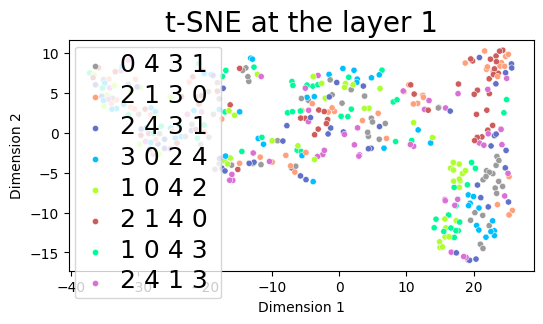

 25%|██▌       | 1/4 [00:00<00:02,  1.07it/s]

['0 4 3 1 ,', '2 4 1 3 ,', '2 1 3 0 ,', '3 0 2 4 ,', '1 0 4 3 ,', '2 4 3 1 ,', '1 0 4 2 ,', '2 1 4 0 ,', '3 0 4 1 ,', '1 2 0 3 ,', '1 4 3 0 ,', '4 0 2 1 ,', '4 0 3 2 ,', '4 2 3 1 ,', '0 4 2 1 ,', '3 4 1 0 ,', '1 3 4 2 ,', '3 2 4 1 ,', '0 1 4 3 ,', '4 3 0 1 ,', '3 1 2 0 ,', '2 4 1 0 ,', '3 2 1 4 ,', '4 0 3 1 ,', '3 4 0 2 ,', '2 4 0 3 ,', '1 0 2 4 ,', '2 1 0 4 ,', '2 0 1 3 ,', '0 2 1 4 ,', '0 2 3 1 ,', '3 1 0 2 ,', '4 2 0 3 ,', '1 0 2 3 ,', '4 3 2 1 ,', '3 1 4 0 ,', '4 2 1 3 ,', '1 3 0 2 ,', '0 3 2 4 ,', '2 1 4 3 ,', '1 3 2 4 ,', '3 0 5 1 ,', '4 3 1 2 ,', '2 4 3 0 ,', '2 1 3 4 ,', '1 0 3 2 ,', '3 1 0 4 ,', '4 0 1 2 ,', '4 3 1 0 ,', '1 2 4 5 ,', '1 3 0 4 ,', '1 3 2 0 ,', '4 0 2 3 ,', '2 5 4 1 ,', '0 1 2 4 ,', '1 4 0 2 ,', '0 2 1 3 ,', '2 3 0 1 ,', '0 2 4 1 ,', '3 4 2 0 ,', '2 3 4 1 ,', '3 2 4 0 ,', '1 2 3 0 ,', '4 3 2 0 ,', '2 0 4 1 ,', '0 4 1 3 ,', '0 3 1 4 ,', '0 3 2 1 ,', '5 0 4 1 ,', '2 1 0 3 ,', '0 3 4 2 ,', '1 4 2 0 ,', '1 3 4 0 ,', '1 4 3 2 ,', '2 3 0 4 ,', '4 1 0 2 ,', '0 4 3 2 ,'

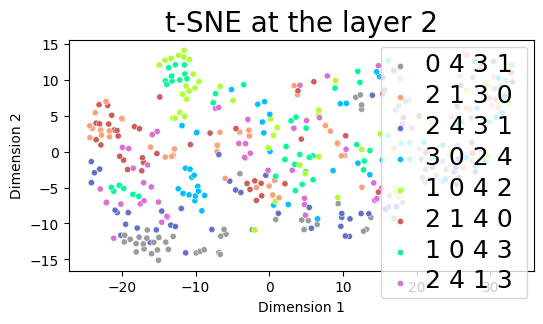

 50%|█████     | 2/4 [00:01<00:01,  1.03it/s]

['0 4 3 1 ,', '2 4 1 3 ,', '2 1 3 0 ,', '3 0 2 4 ,', '1 0 4 3 ,', '2 4 3 1 ,', '1 0 4 2 ,', '2 1 4 0 ,', '3 0 4 1 ,', '1 2 0 3 ,', '1 4 3 0 ,', '4 0 2 1 ,', '4 0 3 2 ,', '4 2 3 1 ,', '0 4 2 1 ,', '3 4 1 0 ,', '1 3 4 2 ,', '3 2 4 1 ,', '0 1 4 3 ,', '4 3 0 1 ,', '3 1 2 0 ,', '2 4 1 0 ,', '3 2 1 4 ,', '4 0 3 1 ,', '3 4 0 2 ,', '2 4 0 3 ,', '1 0 2 4 ,', '2 1 0 4 ,', '2 0 1 3 ,', '0 2 1 4 ,', '0 2 3 1 ,', '3 1 0 2 ,', '4 2 0 3 ,', '1 0 2 3 ,', '4 3 2 1 ,', '3 1 4 0 ,', '4 2 1 3 ,', '1 3 0 2 ,', '0 3 2 4 ,', '2 1 4 3 ,', '1 3 2 4 ,', '3 0 5 1 ,', '4 3 1 2 ,', '2 4 3 0 ,', '2 1 3 4 ,', '1 0 3 2 ,', '3 1 0 4 ,', '4 0 1 2 ,', '4 3 1 0 ,', '1 2 4 5 ,', '1 3 0 4 ,', '1 3 2 0 ,', '4 0 2 3 ,', '2 5 4 1 ,', '0 1 2 4 ,', '1 4 0 2 ,', '0 2 1 3 ,', '2 3 0 1 ,', '0 2 4 1 ,', '3 4 2 0 ,', '2 3 4 1 ,', '3 2 4 0 ,', '1 2 3 0 ,', '4 3 2 0 ,', '2 0 4 1 ,', '0 4 1 3 ,', '0 3 1 4 ,', '0 3 2 1 ,', '5 0 4 1 ,', '2 1 0 3 ,', '0 3 4 2 ,', '1 4 2 0 ,', '1 3 4 0 ,', '1 4 3 2 ,', '2 3 0 4 ,', '4 1 0 2 ,', '0 4 3 2 ,'

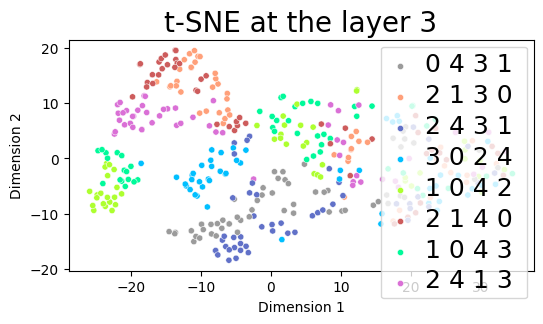

 75%|███████▌  | 3/4 [00:02<00:00,  1.03it/s]

['0 4 3 1 ,', '2 4 1 3 ,', '2 1 3 0 ,', '3 0 2 4 ,', '1 0 4 3 ,', '2 4 3 1 ,', '1 0 4 2 ,', '2 1 4 0 ,', '3 0 4 1 ,', '1 2 0 3 ,', '1 4 3 0 ,', '4 0 2 1 ,', '4 0 3 2 ,', '4 2 3 1 ,', '0 4 2 1 ,', '3 4 1 0 ,', '1 3 4 2 ,', '3 2 4 1 ,', '0 1 4 3 ,', '4 3 0 1 ,', '3 1 2 0 ,', '2 4 1 0 ,', '3 2 1 4 ,', '4 0 3 1 ,', '3 4 0 2 ,', '2 4 0 3 ,', '1 0 2 4 ,', '2 1 0 4 ,', '2 0 1 3 ,', '0 2 1 4 ,', '0 2 3 1 ,', '3 1 0 2 ,', '4 2 0 3 ,', '1 0 2 3 ,', '4 3 2 1 ,', '3 1 4 0 ,', '4 2 1 3 ,', '1 3 0 2 ,', '0 3 2 4 ,', '2 1 4 3 ,', '1 3 2 4 ,', '3 0 5 1 ,', '4 3 1 2 ,', '2 4 3 0 ,', '2 1 3 4 ,', '1 0 3 2 ,', '3 1 0 4 ,', '4 0 1 2 ,', '4 3 1 0 ,', '1 2 4 5 ,', '1 3 0 4 ,', '1 3 2 0 ,', '4 0 2 3 ,', '2 5 4 1 ,', '0 1 2 4 ,', '1 4 0 2 ,', '0 2 1 3 ,', '2 3 0 1 ,', '0 2 4 1 ,', '3 4 2 0 ,', '2 3 4 1 ,', '3 2 4 0 ,', '1 2 3 0 ,', '4 3 2 0 ,', '2 0 4 1 ,', '0 4 1 3 ,', '0 3 1 4 ,', '0 3 2 1 ,', '5 0 4 1 ,', '2 1 0 3 ,', '0 3 4 2 ,', '1 4 2 0 ,', '1 3 4 0 ,', '1 4 3 2 ,', '2 3 0 4 ,', '4 1 0 2 ,', '0 4 3 2 ,'

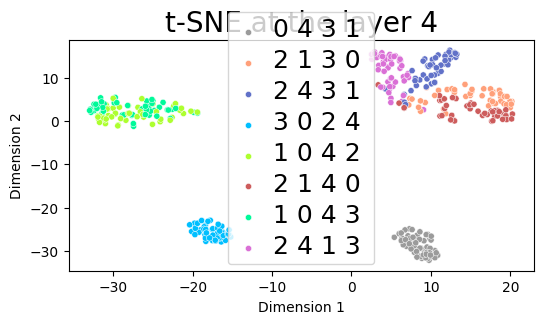

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

['0 4 3 1 ,', '2 4 1 3 ,', '2 1 3 0 ,', '3 0 2 4 ,', '1 0 4 3 ,', '2 4 3 1 ,', '1 0 4 2 ,', '2 1 4 0 ,', '3 0 4 1 ,', '1 2 0 3 ,', '1 4 3 0 ,', '4 0 2 1 ,', '4 0 3 2 ,', '4 2 3 1 ,', '0 4 2 1 ,', '3 4 1 0 ,', '1 3 4 2 ,', '3 2 4 1 ,', '0 1 4 3 ,', '4 3 0 1 ,', '3 1 2 0 ,', '2 4 1 0 ,', '3 2 1 4 ,', '4 0 3 1 ,', '3 4 0 2 ,', '2 4 0 3 ,', '1 0 2 4 ,', '2 1 0 4 ,', '2 0 1 3 ,', '0 2 1 4 ,', '0 2 3 1 ,', '3 1 0 2 ,', '4 2 0 3 ,', '1 0 2 3 ,', '4 3 2 1 ,', '3 1 4 0 ,', '4 2 1 3 ,', '1 3 0 2 ,', '0 3 2 4 ,', '2 1 4 3 ,', '1 3 2 4 ,', '3 0 5 1 ,', '4 3 1 2 ,', '2 4 3 0 ,', '2 1 3 4 ,', '1 0 3 2 ,', '3 1 0 4 ,', '4 0 1 2 ,', '4 3 1 0 ,', '1 2 4 5 ,', '1 3 0 4 ,', '1 3 2 0 ,', '4 0 2 3 ,', '2 5 4 1 ,', '0 1 2 4 ,', '1 4 0 2 ,', '0 2 1 3 ,', '2 3 0 1 ,', '0 2 4 1 ,', '3 4 2 0 ,', '2 3 4 1 ,', '3 2 4 0 ,', '1 2 3 0 ,', '4 3 2 0 ,', '2 0 4 1 ,', '0 4 1 3 ,', '0 3 1 4 ,', '0 3 2 1 ,', '5 0 4 1 ,', '2 1 0 3 ,', '0 3 4 2 ,', '1 4 2 0 ,', '1 3 4 0 ,', '1 4 3 2 ,', '2 3 0 4 ,', '4 1 0 2 ,', '0 4 3 2 ,'

In [ ]:
import numpy as np
triangle_lens=3
key='values'
attn_list=attn_list_dicts[key]
print(len(attn_list[0][0]))
data_list=[]
vis_label_list=[]
q_data_list=[]
q_label_list=[]
for l in tqdm(range(len(attn_list[0][0])),total=len(attn_list[0][0])): # traveling layers
    # print(l,k)
    for k in range(1):
        data_list=[]
        vis_label_list=[]
        q_data_list=[]
        q_label_list=[]
        for i in range(len(ans_label_list)):# samples
        
            attn_data=attn_list[i]# .squeeze()
            attn=attn_data[k][l].squeeze()
            # print(attn.shape)
            merge_data=get_vis_data3(response_list[i],label_list[i],attn,read_idx=k+1)
            tmp_string=sorted_dict_list[ans_label_list[i]][:-2]
            tmp_string=tmp_string.split(' ')
            tmp_label=''
            for i in range(len(attn_list[0][0])+1):
                try:
                    tmp_label+=tmp_string[i]+' '
                except:
                    continue
            data_list.extend(merge_data)
            vis_label_list.append(tmp_label)
        data_list=np.array(data_list)
        print(set(vis_label_list))
        print('datas',data_list.shape)
        get_tsne_fig(data_list,vis_label_list,layer=l+1,step=k)
        print(sorted_dict_list)

In [33]:
key='attn_y'
attn_list=attn_list_dicts[key]
print(len(attn_list))
print(len(attn_list[0]))
print(len(attn_list[0][0]))
print(len(attn_list[0][0][0]))
print(attn_list[0][0][0].shape)

157
3
4
1
(1, 300, 384)


In [35]:
key='lm_head_x'
attn_list=attn_list_dicts[key]
print(len(attn_list))
print(len(attn_list[0]))
print(len(attn_list[0][0]))
print(len(attn_list[0][0][0]))
print(attn_list[0][0][0].shape)

157
3
1
1
(1, 1, 384)
